# Regular RL Trainining Pipeline for PPO Agent to Play Levels from the Doom Game

In [1]:
from utils.env import make_vizdoom_env
import gymnasium as gym
from datetime import datetime

start_datetime = datetime.now()
start_datetime_timestamp_str = start_datetime.strftime('%Y_%m_%d_%H_%M_%S')

# Initializing environments
num_envs = 8
envs = gym.vector.SyncVectorEnv([ make_vizdoom_env('envs/vizdoom/scenarios/basic.cfg', 
                                                #    render_mode='rgb_array', 
                                                #    record_episodes=True,
                                                #    recording_save_path=f"./videos/rl_pipeline/training_run_{start_datetime_timestamp_str}"
                                                  ) for i in range(num_envs)])


/Users/harish/opt/anaconda3/envs/doom-rlhf/lib/python3.9/site-packages/gymnasium/core.py:297: UserWarning: WARN: env.num_envs to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.num_envs` for environment variables or `env.get_attr('num_envs')` that will search the reminding wrappers.
  logger.warn(


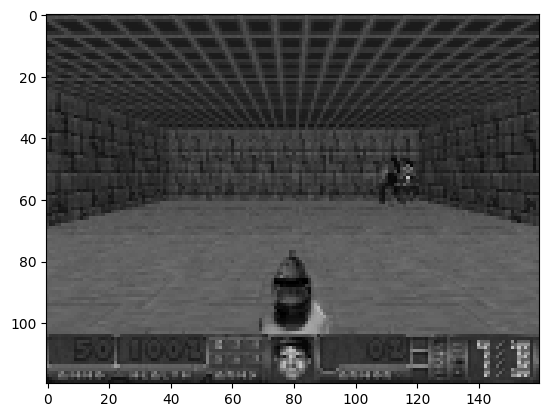

In [2]:
import cv2
from matplotlib import pyplot as plt

observations, info = envs.reset()

plt.imshow(cv2.cvtColor(observations[0][0], cv2.COLOR_GRAY2RGB))


In [2]:
from torch.utils.tensorboard import SummaryWriter
from agents.doom_ppo_agent import DoomPpoAgent
from utils.replay_buffer import ReplayBuffer
from utils.time import current_timestamp_ms

# Setting up agent
agent = DoomPpoAgent(envs.single_observation_space, 
                     envs.single_action_space,
                     learning_rate=0.0001,
                     use_gpu=True)

# Setting up agent training config
global_step = 0
start_time = start_datetime.timestamp()
num_steps = 256
num_mini_batches = 32
num_training_epochs=10
batch_size = int(num_envs * num_steps)
mini_batch_size = batch_size // num_mini_batches
total_timesteps = 900000
num_updates = total_timesteps // batch_size
replay_buffer = ReplayBuffer(num_steps, num_envs, envs.single_observation_space, envs.single_action_space)

# Setting up debugging for Tensorboard
tensorboard_writer = SummaryWriter(f"logs/ppo_agent/doom_basic_level/training_{current_timestamp_ms()}")

In [3]:
import numpy as np
import time

observations, info = envs.reset()
dones = [ 0 for _ in range(num_envs) ]
best_average_return = float('-inf')
returns = []

for update in range(1, num_updates + 1):
    # Calculating learning rate annealing coefficient
    learning_rate_anneal_coef = 1.0 - (update - 1.0) / num_updates

    for step in range(0, num_steps):
        global_step += num_envs

        # Getting next action and it's value
        actions, log_probs, probs, values = agent.forward(observations)
        values = values.flatten()

        observations_, rewards, dones_, truncation_statuses, info = envs.step(actions)

        # Saving transitions in replay buffer
        replay_buffer.record_transition_step(
            step, 
            observations,
            actions,
            log_probs,
            rewards,
            values,
            dones
        )

        # Saving new observation and done status for next step
        observations = observations_
        dones =  dones_
        
        if 'final_info' in info:
            for env_info in info['final_info']:
                if env_info is not None and "episode" in env_info.keys():
                    print(f"global_step={global_step}, episodic_return={env_info['episode']['r']}")

                    # Recording returns
                    returns.append(env_info['episode']['r'])

                    # Writing step debug info to TensorBoard
                    tensorboard_writer.add_scalar("charts/episodic_return", env_info["episode"]["r"], global_step)
                    tensorboard_writer.add_scalar("charts/episodic_length", env_info["episode"]["l"], global_step)
                    break

    # Checking if the current mean is higher than previous highest mean and saving the model
    current_mean_episodic_return = np.mean(returns)
    print(f"Current Mean Episodic Return = {current_mean_episodic_return}")
    if current_mean_episodic_return > best_average_return:
        # Saving the model
        agent.save_models(f"./models/doom_ppo_agent/rl_pipeline/training_run_{start_datetime_timestamp_str}/checkpoint_step_{global_step}")
        
        # Saving new best average return and clearing returns arrays
        best_average_return = current_mean_episodic_return
        returns.clear()
    
    # Training the agent
    training_stats = agent.train(
        replay_buffer=replay_buffer,
        learning_rate_anneal_coef=learning_rate_anneal_coef,
        mini_batch_size=mini_batch_size,
        num_training_epochs=num_training_epochs
    )

    print("SPS:", int(global_step / (time.time() - start_time)))

    tensorboard_writer.add_scalar("charts/learning_rate", training_stats.learning_rate, global_step)
    tensorboard_writer.add_scalar("losses/value_loss", training_stats.value_loss, global_step)
    tensorboard_writer.add_scalar("losses/policy_loss", training_stats.policy_loss, global_step)
    tensorboard_writer.add_scalar("losses/entropy_loss", training_stats.entropy_loss, global_step)
    tensorboard_writer.add_scalar("charts/old_approx_kl", training_stats.old_approx_kl, global_step)
    tensorboard_writer.add_scalar("charts/approx_kl", training_stats.approx_kl, global_step)
    tensorboard_writer.add_scalar("charts/clip_fraction", training_stats.clip_fraction, global_step)
    tensorboard_writer.add_scalar("charts/explained_variance", training_stats.explained_variance, global_step)
    tensorboard_writer.add_scalar("charts/SPS", int(global_step / (time.time() - start_time)), global_step)


global_step=48, episodic_return=[95.]
global_step=296, episodic_return=[65.]
global_step=2040, episodic_return=[-209.]
Current Mean Episodic Return = -16.33333396911621
Saving models...
Directory './models/doom_ppo_agent/rl_pipeline/training_run_2023_07_20_21_58_01/checkpoint_step_2048' created!
Successfully saved models!
observations.shape = torch.Size([256, 8, 4, 120, 160])
actions.shape = torch.Size([256, 8])
log_probs.shape = torch.Size([256, 8])
rewards.shape = torch.Size([256, 8])
values.shape = torch.Size([256, 8])
dones.shape = torch.Size([256, 8])


AttributeError: 'ReplayBuffer' object has no attribute 'clear'

In [ ]:
# Saving models
agent.save_models()

In [ ]:
# Closing environments
envs.close()
# Closing tensorboard writer
tensorboard_writer.close()